In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import time
import random

In [2]:
np.random.seed(42)
random.seed(42)

# version modificada
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        # hyperparameters
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        # initialize model parameters
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))
        
        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)
    
    def forward_pass(self, inputs, targets, hprev):
        """
        inputs -- list of integers (tokenizer: char to int)
        targets -- list of integers (tokenizer: char to int)
        hprev -- the initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0
    
        for t in range(len(inputs)):
            
            # one hot encoder of a char
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss = loss - np.log(p[t][targets[t], 0])
            
        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, *, do_clipping):
        
        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])
        
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] =  dy[targets[t]] - 1
            dWhy = dWhy + dy @ h[t].T
            dby = dby + dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh = dbh + dhraw
            dWxh = dWxh + dhraw @ x[t].T
            dWhh = dWhh + dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        if do_clipping:
            for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
                np.clip(dpara, -5, 5, out = dpara)
            
        return dWxh, dWhh, dWhy, dbh, dby
    
    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(['Wxh', 'Whh', 'Why', 'bh', 'by'], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):
            
            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) - self.learning_rate * dpara/np.sqrt(getattr(self, mem) + 1e-8))
            
    def plot(self, values, type):
        plt.plot(range(1, len(values) + 1), values)
        
        # Add title and axes labels
        plt.title(f'{type} vs Iteraciones')
        plt.xlabel('Iteracion')
        plt.ylabel(f'{type}')

        plt.show()

    def train(self, inputs, char_to_int, int_to_char, max_iter = 1e4, *,
              do_plot_loss = True, do_plot_perplexity = True, do_clipping = True):
        
        iter_num, position = 0, 0
        loss_list = []
        perplexity_list = []
        loss_list.append(- np.log(1 / self.n_x) * self.seq_length)        
        
        while iter_num <= max_iter:
            if iter_num%1000 ==0: print(iter_num)
            ## reset the rnn after an epoch
            if position + self.seq_length + 1 >= len(inputs) or iter_num == 0: 
                hprev = np.zeros((self.n_h, 1))
                position = 0
                
            ## chars to int
            input_bacth = [char_to_int[ch] for ch in inputs[position:position + self.seq_length]]
            target_bacth = [char_to_int[ch] for ch in inputs[position + 1 : position + self.seq_length + 1]]
            position = position + self.seq_length
            ## forward_pass
            loss, x, h, p = self.forward_pass(input_bacth, target_bacth, hprev)
            loss_list.append(loss_list[-1] * 0.999 + loss * 0.001)
            perplexity_list.append(np.exp(loss/len(inputs)))
            ## backpropagation
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p,
                                                              target_bacth,
                                                              do_clipping=do_clipping)
            ## adagrad upate
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]
            
            iter_num = iter_num + 1
            
        ## make a sample after training
        sample_ix = self.make_sample(hprev, target_bacth[-1], 200)
        sample_char = ''.join(int_to_char[ix] for ix in sample_ix)
        if do_plot_loss:
            self.plot(loss_list, "loss")
        
        if do_plot_perplexity:
            self.plot(perplexity_list, "perplexity")
        
        return loss_list, sample_char, perplexity_list

            
    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)
        
        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

In [ ]:
# Cargamos los nombres masculinos
with open('male.txt', 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

# Construimos una cadena continua separando por '\n'
words = '\n'.join(lines) + '\n'  # añadimos un newline final para que el último nombre tenga target
print(f"Nombres cargados: {len(lines)}")
print(f"Longitud total del corpus (caracteres): {len(words)}")
print("Ejemplos (primeros 10 nombres):")
print('\n'.join(lines[:10]))

# vocab (ordenado para reproducibilidad)
chars = sorted(list(set(words)))
vocab_size = len(chars)
char_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_char = {i:ch for i,ch in enumerate(chars)}
print(f"Vocab size: {vocab_size}")
print("Primeros pares token<->char:", list(char_to_int.items())[:10])


Nombres cargados: 2943
Longitud total del corpus (caracteres): 20293
Ejemplos (primeros 10 nombres):
Aamir
Aaron
Abbey
Abbie
Abbot
Abbott
Abby
Abdel
Abdul
Abdulkarim
Vocab size: 54
Primeros pares token<->char: [('\n', 0), ('-', 1), ('A', 2), ('B', 3), ('C', 4), ('D', 5), ('E', 6), ('F', 7), ('G', 8), ('H', 9)]


In [5]:
# Funciones auxiliares para correr experimentos y mostrar resultados
def extract_names_from_sample(sample_str: str, max_names: int = 20) -> List[str]:
    """
    Dado el texto muestreado por el modelo (con \n como separador),
    devuelve una lista de nombres no vacíos.
    """
    # splitlines preserva sin '\n'
    parts = [p.strip() for p in sample_str.split('\n') if p.strip()]
    return parts[:max_names]

def run_experiment(cfg: dict, corpus: str, char_to_int: dict, int_to_char: dict):
    """
    cfg: diccionario con keys: n_h, seq_length, max_iter, learning_rate, do_clipping, dataset_percent
    corpus: cadena completa (words)
    """
    print("\n" + "="*60)
    print("EXPERIMENTO:", cfg)
    # possibly reduce dataset size
    dataset_percent = cfg.get('dataset_percent', 1.0)
    if dataset_percent < 1.0:
        # reduce by number of names
        all_lines = corpus.splitlines()
        k = max(1, int(len(all_lines) * dataset_percent))
        truncated = '\n'.join(all_lines[:k]) + '\n'
        data = truncated
        print(f"Usando {k} nombres de {len(all_lines)} ({dataset_percent*100:.1f}%)")
    else:
        data = corpus
    
    rnn = vanillaRNN(n_x = vocab_size,
                     n_h = cfg['n_h'],
                     seq_length = cfg['seq_length'],
                     learning_rate = cfg.get('learning_rate', 1e-1))
    t0 = time.time()
    loss_list, sample_char, perplexity_list = rnn.train(data, char_to_int, int_to_char,
                                                        max_iter=cfg['max_iter'],
                                                        do_plot_loss=False, do_plot_perplexity=False,
                                                        do_clipping=cfg.get('do_clipping', True))
    t1 = time.time()
    print(f"Tiempo de entrenamiento: {t1-t0:.1f}s")
    
    # plots
    plt.figure(figsize=(10,4))
    plt.plot(loss_list)
    plt.title(f"Loss (smoothed) — {cfg}")
    plt.xlabel("Iteracion")
    plt.ylabel("Loss (suavizado)")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.plot(perplexity_list)
    plt.title(f"Perplexity por token — {cfg}")
    plt.xlabel("Iteracion")
    plt.ylabel("Perplexity")
    plt.grid(True)
    plt.show()
    
    # Extraer nombres del muestreo
    generated = extract_names_from_sample(sample_char, max_names=30)
    print("Nombres generados (primeros 10):")
    for i, nm in enumerate(generated[:10]):
        print(f"{i+1:2d}. {nm}")
    
    return {
        'cfg': cfg,
        'loss_list': loss_list,
        'perplexity_list': perplexity_list,
        'sample_text': sample_char,
        'generated_names': generated,
        'rnn': rnn
    }



EXPERIMENTO: {'name': 'exp_small_short', 'n_h': 50, 'seq_length': 8, 'max_iter': 2000, 'learning_rate': 0.1, 'do_clipping': True, 'dataset_percent': 1.0}
0
1000
2000
Tiempo de entrenamiento: 0.8s


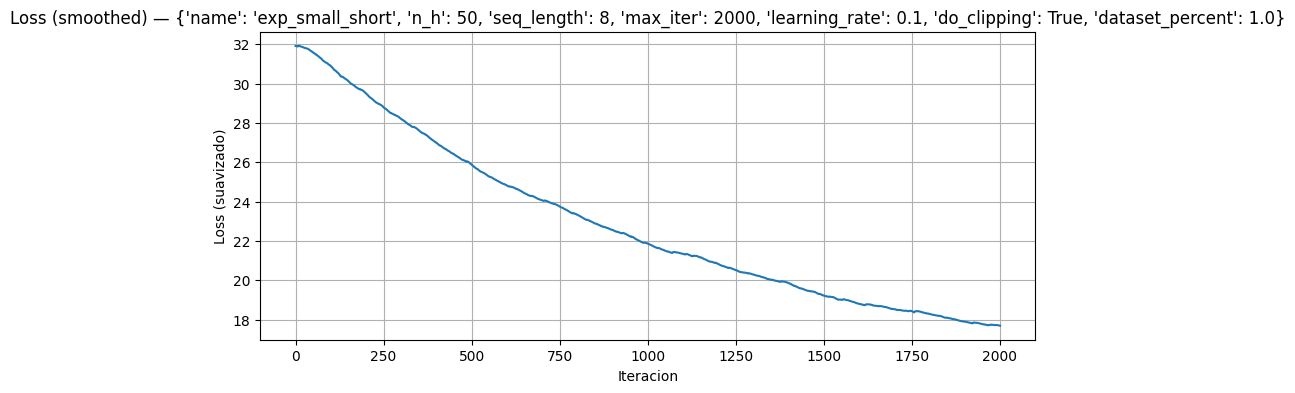

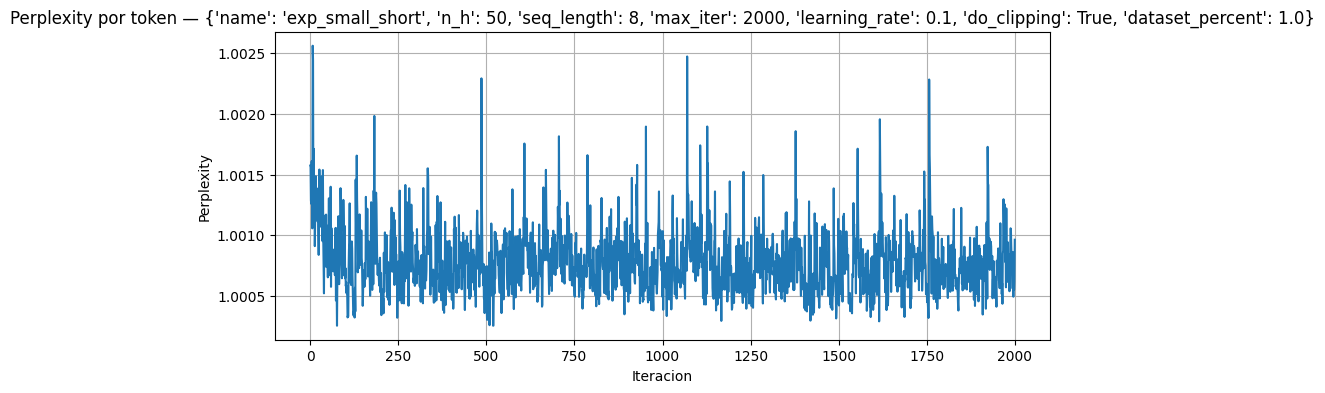

Nombres generados (primeros 10):
 1. hgac
 2. Shlot
 3. Shafhh
 4. Siumo
 5. Sherfu
 6. Seuag
 7. Sehey
 8. Sinneci
 9. Suon
10. Shey

EXPERIMENTO: {'name': 'exp_med_long', 'n_h': 100, 'seq_length': 25, 'max_iter': 5000, 'learning_rate': 0.1, 'do_clipping': True, 'dataset_percent': 1.0}
0
1000
2000
3000
4000
5000
Tiempo de entrenamiento: 9.3s


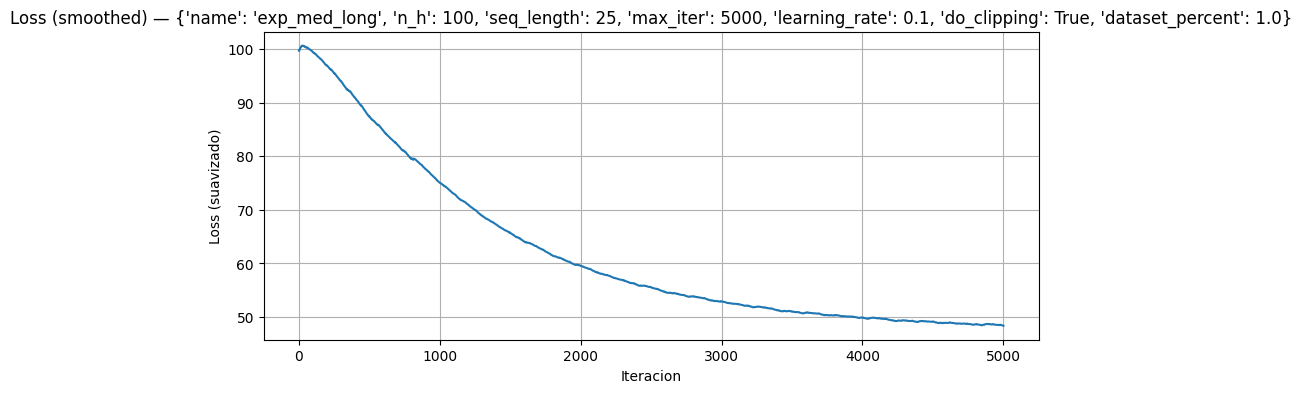

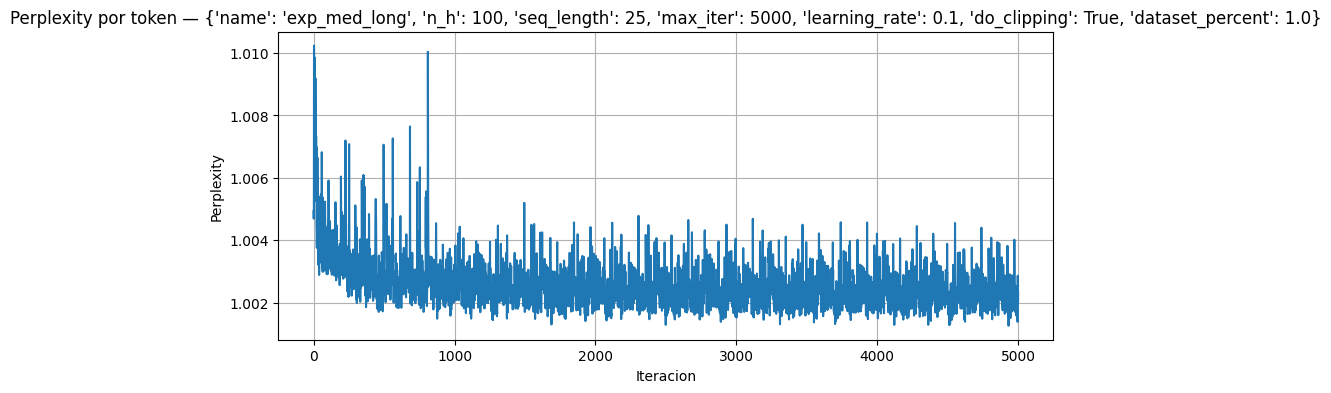

Nombres generados (primeros 10):
 1. Carte
 2. Clwittie
 3. Corts
 4. Corily
 5. Cladtse
 6. Corkosini
 7. Chayes
 8. Chak
 9. Chyril
10. Cartle

EXPERIMENTO: {'name': 'exp_med_noclip', 'n_h': 100, 'seq_length': 25, 'max_iter': 5000, 'learning_rate': 0.1, 'do_clipping': False, 'dataset_percent': 1.0}
0
1000
2000
3000
4000
5000
Tiempo de entrenamiento: 11.2s


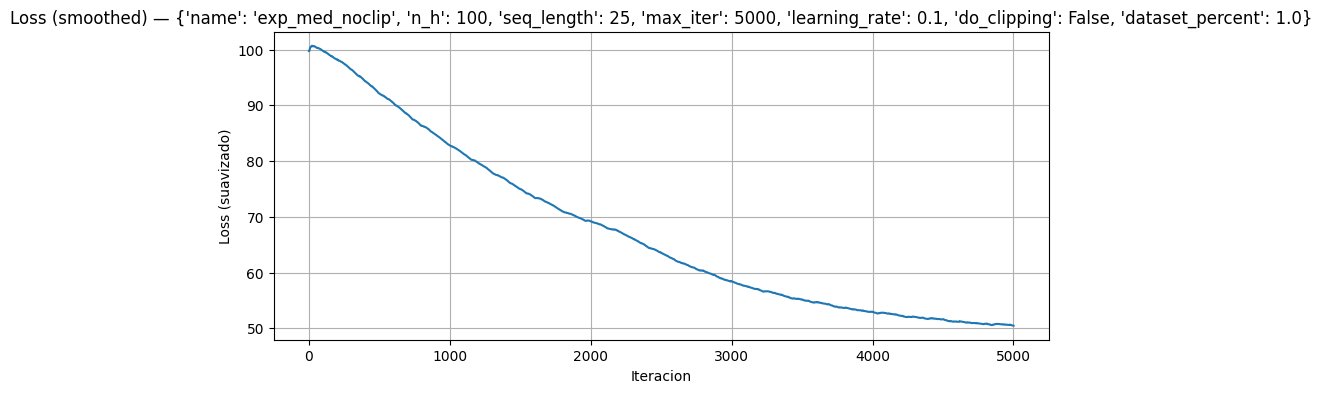

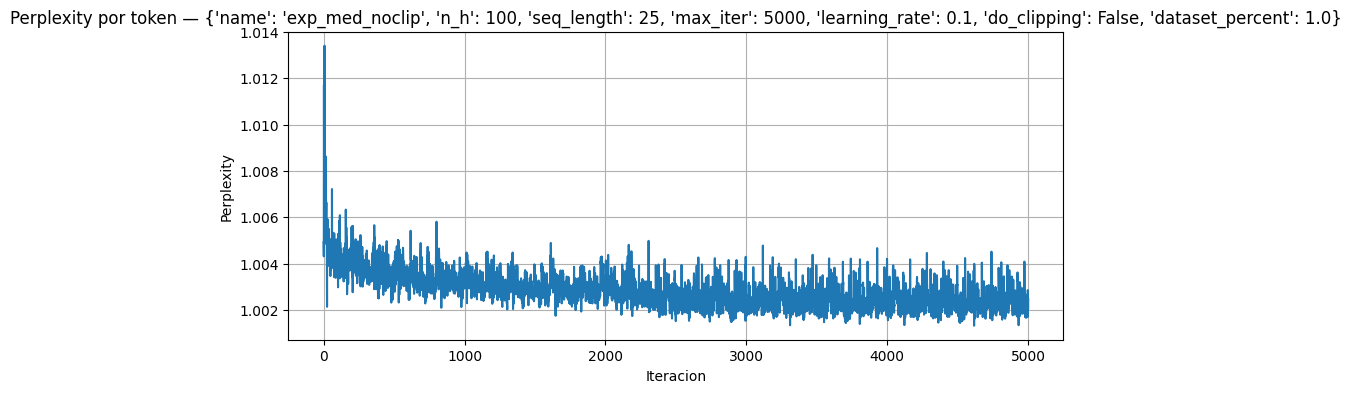

Nombres generados (primeros 10):
 1. Chita
 2. Clery
 3. Cranue
 4. Oltee
 5. Choly
 6. Corrie
 7. Chicker
 8. Clauros
 9. Charle
10. Chreidrichchy

EXPERIMENTO: {'name': 'exp_small_dataset', 'n_h': 100, 'seq_length': 25, 'max_iter': 4000, 'learning_rate': 0.1, 'do_clipping': True, 'dataset_percent': 0.2}
Usando 588 nombres de 2943 (20.0%)
0
1000
2000
3000
4000
Tiempo de entrenamiento: 9.5s


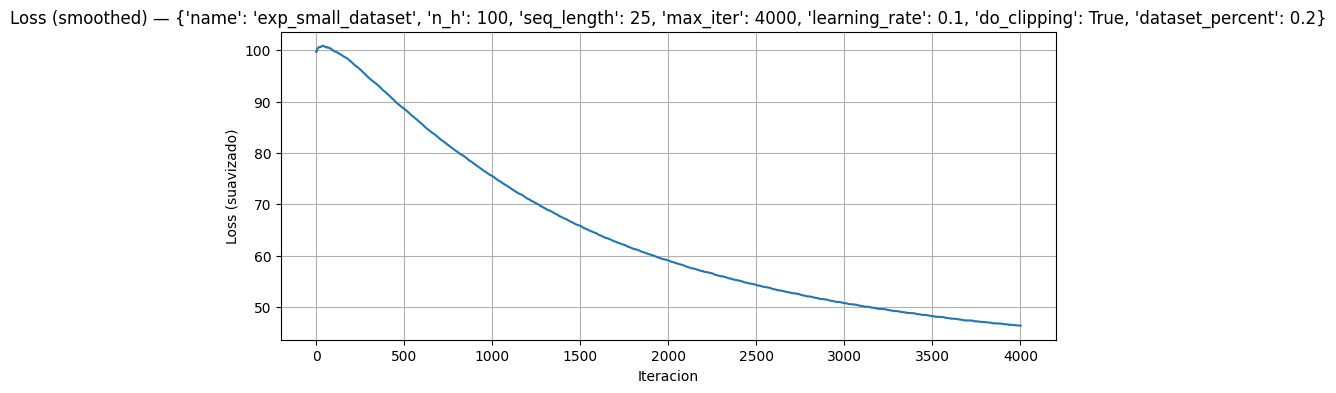

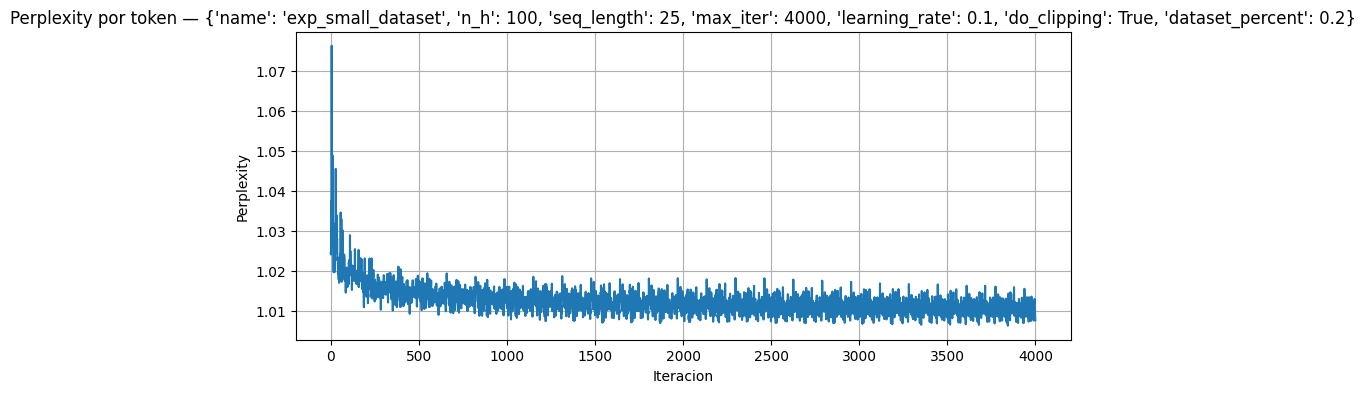

Nombres generados (primeros 10):
 1. em
 2. Bart
 3. Biariled
 4. sar
 5. Cobd
 6. Blapheft
 7. Bunhne
 8. Abansjis
 9. Banyno
10. Berbele

EXPERIMENTO: {'name': 'exp_large_long', 'n_h': 200, 'seq_length': 50, 'max_iter': 7000, 'learning_rate': 0.1, 'do_clipping': True, 'dataset_percent': 1.0}
0
1000
2000
3000
4000
5000
6000
7000
Tiempo de entrenamiento: 48.1s


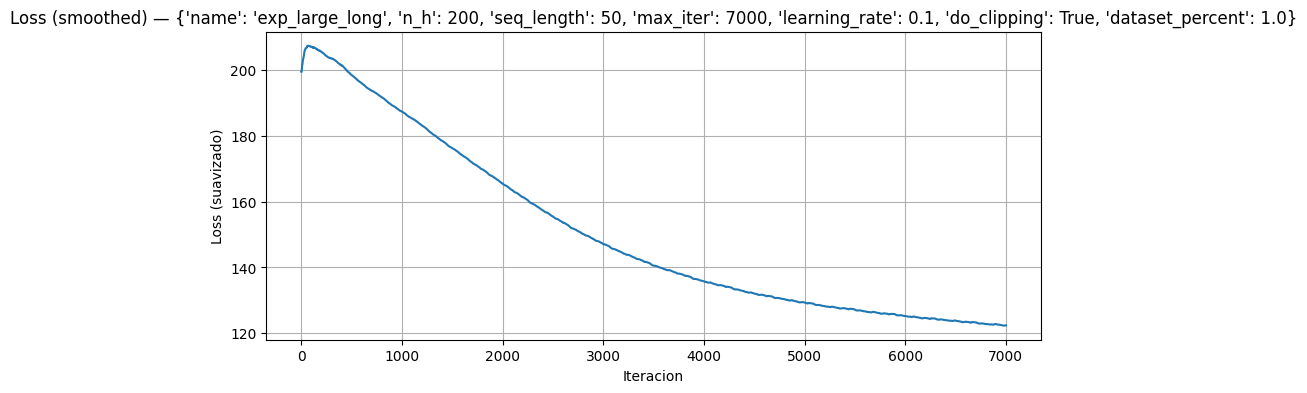

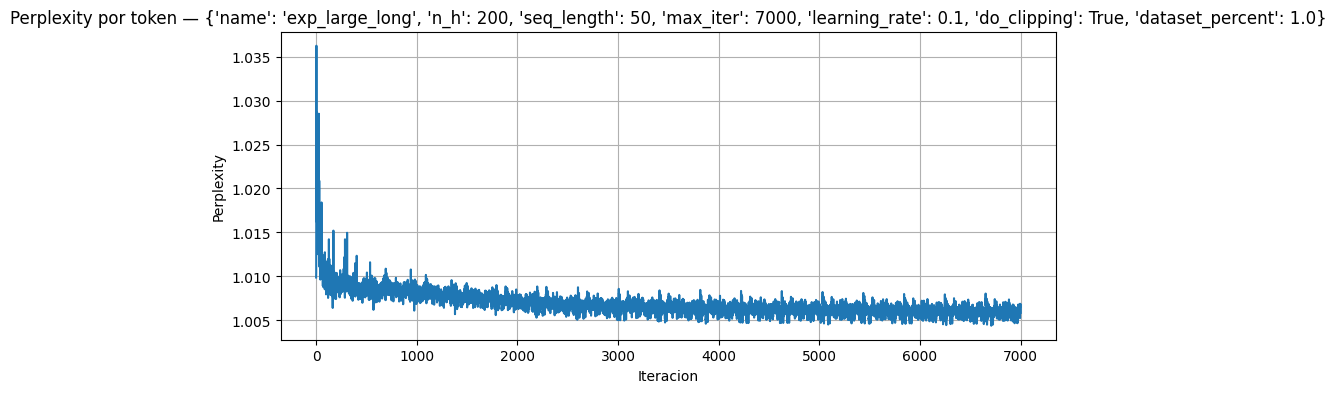

Nombres generados (primeros 10):
 1. GKegaln
 2. Baowewie
 3. -uimc
 4. Derenol
 5. Chloce
 6. Dicy
 7. M
 8. Chliendie
 9. Tesy
10. Skouer-l

EXPERIMENTO: {'name': 'exp_large_lr_low', 'n_h': 200, 'seq_length': 50, 'max_iter': 7000, 'learning_rate': 0.01, 'do_clipping': True, 'dataset_percent': 1.0}
0
1000
2000
3000
4000
5000
6000
7000
Tiempo de entrenamiento: 45.3s


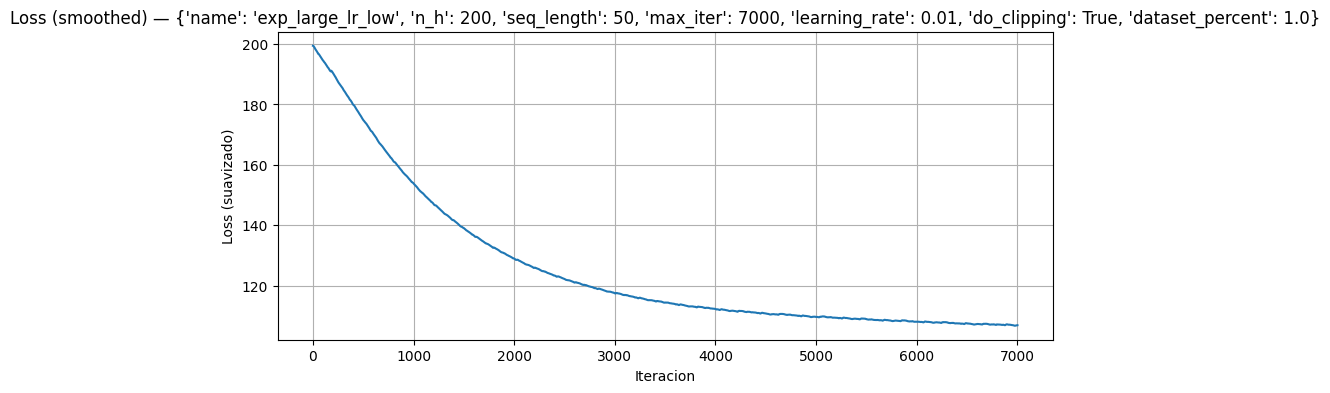

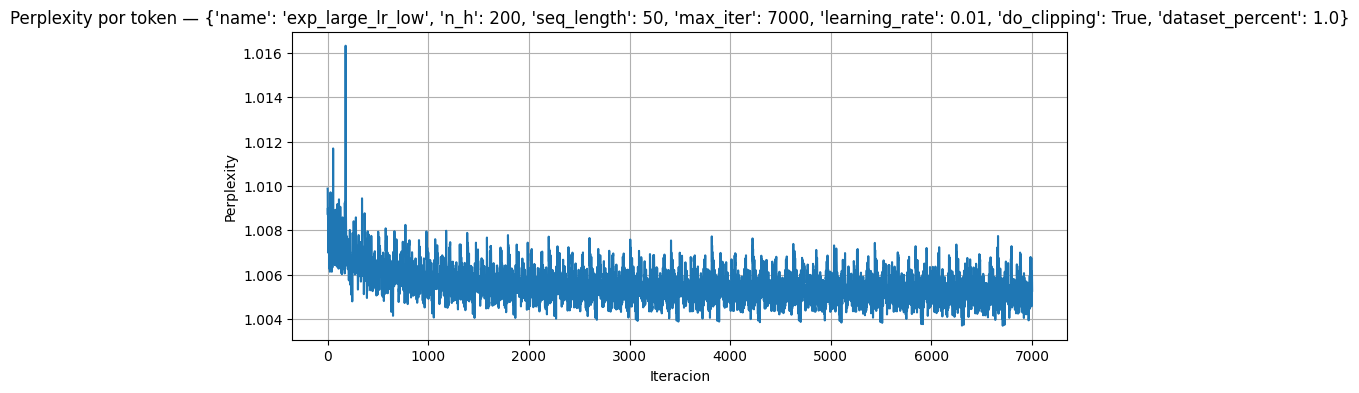

Nombres generados (primeros 10):
 1. Eleviae
 2. Flgalce
 3. Coldiljas
 4. yiser
 5. Eitas
 6. Gnisxelo
 7. Elbahtd
 8. EadiGee
 9. Ceanolie
10. Homerry


In [8]:
experiments = [
    # 1. Modelo pequeño y secuencia corta
    {'name': 'exp_small_short', 'n_h': 50, 'seq_length': 8, 'max_iter': 2000,
     'learning_rate': 1e-1, 'do_clipping': True, 'dataset_percent': 1.0},

    # 2. Modelo mediano y secuencia larga
    {'name': 'exp_med_long', 'n_h': 100, 'seq_length': 25, 'max_iter': 5000,
     'learning_rate': 1e-1, 'do_clipping': True, 'dataset_percent': 1.0},

    # 3. Igual al anterior pero sin gradient clipping
    {'name': 'exp_med_noclip', 'n_h': 100, 'seq_length': 25, 'max_iter': 5000,
     'learning_rate': 1e-1, 'do_clipping': False, 'dataset_percent': 1.0},

    # 4. Conjunto de datos reducido al 20%
    {'name': 'exp_small_dataset', 'n_h': 100, 'seq_length': 25, 'max_iter': 4000,
     'learning_rate': 1e-1, 'do_clipping': True, 'dataset_percent': 0.2},

    # 5. Modelo grande y secuencia extensa
    {'name': 'exp_large_long', 'n_h': 200, 'seq_length': 50, 'max_iter': 7000,
     'learning_rate': 1e-1, 'do_clipping': True, 'dataset_percent': 1.0},

    # 6. Modelo grande con tasa de aprendizaje reducida
    {'name': 'exp_large_lr_low', 'n_h': 200, 'seq_length': 50, 'max_iter': 7000,
     'learning_rate': 1e-2, 'do_clipping': True, 'dataset_percent': 1.0},
]

# Ejecutar experimentos secuencialmente
results = []
for cfg in experiments:
    res = run_experiment(cfg, words, char_to_int, int_to_char)
    results.append(res)

In [9]:
print("\nResumen final de experimentos:")
for res in results:
    cfg = res['cfg']
    print("\n" + "-"*60)
    print(f"Experimento {cfg['name']}: n_h={cfg['n_h']}, seq_len={cfg['seq_length']}, max_iter={cfg['max_iter']}, clipping={cfg['do_clipping']}, dataset%={cfg.get('dataset_percent',1.0)}")
    gen = res['generated_names']
    print("Ejemplo de 10 nombres generados:")
    for i, nm in enumerate(gen[:10]):
        print(f" {i+1:2d}. {nm}")
    # Si quieres generar más nombres nuevos a partir del modelo entrenado:
    rnn = res['rnn']
    # usar seed aleatorio (último char del corpus como semilla):
    seed_ix = char_to_int[words[-2]]  # caracter antes del último '\n'
    sample_ix = rnn.make_sample(np.zeros((rnn.n_h,1)), seed_ix, 500)
    sample_text = ''.join(int_to_char[ix] for ix in sample_ix)
    new_names = extract_names_from_sample(sample_text, max_names=20)
    print("Nuevos nombres (muestreo adicional):")
    for i, nm in enumerate(new_names[:10]):
        print(f" {i+1:2d}. {nm}")


Resumen final de experimentos:

------------------------------------------------------------
Experimento exp_small_short: n_h=50, seq_len=8, max_iter=2000, clipping=True, dataset%=1.0
Ejemplo de 10 nombres generados:
  1. hgac
  2. Shlot
  3. Shafhh
  4. Siumo
  5. Sherfu
  6. Seuag
  7. Sehey
  8. Sinneci
  9. Suon
 10. Shey
Nuevos nombres (muestreo adicional):
  1. ston
  2. Sheran
  3. Saan
  4. Shauraey
  5. Shhas
  6. Seen
  7. Shhene
  8. Sha
  9. Surtonl
 10. Sawhus

------------------------------------------------------------
Experimento exp_med_long: n_h=100, seq_len=25, max_iter=5000, clipping=True, dataset%=1.0
Ejemplo de 10 nombres generados:
  1. Carte
  2. Clwittie
  3. Corts
  4. Corily
  5. Cladtse
  6. Corkosini
  7. Chayes
  8. Chak
  9. Chyril
 10. Cartle
Nuevos nombres (muestreo adicional):
  1. jaod
  2. ory
  3. Ch
  4. Cuvayal
  5. Caram
  6. Carrno
  7. Cu
  8. Ceril
  9. Clamen
 10. Combety

------------------------------------------------------------
Experime